In this notebook, we compare GMM-MI with the [KSG estimator](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) and the [MINE estimator](https://github.com/gtegner/mine-pytorch) on an ordered exponential Weinman distribution with varying free parameter $\alpha$. To run this notebook you would need to install the MINE package following the instructions in the repository; here we already cloned the repository for you and adapted the code to work with python 3.9, so that you only need to run:
```
cd mine-pytorch
pip install -e .
```
Note the MINE results are not "reproducible", in the sense that the seed is not fixed.

### Import packages

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
# GMM-MI
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.utils.analytic_MI import calculate_MI_weinman_analytical
# KSG
from sklearn.feature_selection import mutual_info_regression
# MINE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from mine.models.mine import MutualInformationEstimator
from pytorch_lightning import Trainer
import logging
logging.getLogger().setLevel(logging.ERROR)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = 1 if device=='cuda' else 0

Device: cpu


### Calculate the true MI of the synthetic models

In [2]:
alphas = np.logspace(-1, 2, 20)
N = int(2e2)
# fix random state for stability across runs
random_state = 31
random_gen = np.random.default_rng(random_state)

analytic = []
for alpha in alphas:
    analytic.append(calculate_MI_weinman_analytical(alpha))

### KSG

In [3]:
knn_estimates = []
n_neighbors = 1 # keep minimum bias

initial_time = time.time()

for alpha in alphas:
    beta = 0.5
    x_samples = random_gen.exponential(scale=beta, size=N)
    # then for each x, we sample from an exp
    y_samples = random_gen.exponential(scale = alpha, size=N) + x_samples
    X = np.stack((np.log(x_samples), np.log(y_samples)), axis=0).T
    knn_estimates.append(mutual_info_regression(X[:, 0].reshape(-1, 1), X[:, 1], 
                                                n_neighbors=n_neighbors))

ksg_time = time.time()-initial_time    
    
print(f'Total time for KSG: {ksg_time:.3f} s')

Total time for KSG: 0.036 s


### MINE

In [4]:
mine_estimates = []

dim = 1
lr = 1e-3
epochs = 50
batch_size = 32
loss_type = ['mine']  # mine, mine_biased, fdiv
loss = loss_type[0]

initial_time = time.time()

for alpha in alphas:
    beta = 0.5
    x_samples = random_gen.exponential(scale=beta, size=N)
    # then for each x, we sample from an exp
    y_samples = random_gen.exponential(scale = alpha, size=N) + x_samples
    X = np.stack((np.log(x_samples), np.log(y_samples)), axis=0).T

    N = X.shape[0]
    train_size = int(0.9 * N)
    test_size = N - train_size

    train_set, test_set = train_test_split(X, test_size=0.1, random_state=42)

    tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    kwargs = {
        'lr': lr,
        'batch_size': batch_size,
        'train_loader': train_loader,
        'test_loader': test_loader,
        'alpha': 1.
    }

    model = MutualInformationEstimator(
        dim, dim, loss=loss, **kwargs).to(device)
    
    trainer = Trainer(max_epochs=epochs)
    trainer.fit(model)
    trainer.test()

    mine_estimates.append(model.avg_test_mi)

mine_time = time.time()-initial_time    
    
print(f'Total time for MINE: {mine_time:.3f} s')

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/pytorch_lightnin

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1386: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v100.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v100.ckpt
/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off 

Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v101.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v101.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v102.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v102.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v103.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v103.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v104.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v104.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v105.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v105.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v106.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v106.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v107.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v107.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v108.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v108.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v109.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v109.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v110.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v110.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v111.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v111.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v112.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v112.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v113.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v113.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v114.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v114.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v115.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v115.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v116.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v116.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v117.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v117.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v118.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v118.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v119.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_480432/checkpoints/epoch=49-step=300-v119.ckpt


Testing: 0it [00:00, ?it/s]

Total time for MINE: 61.012 s


### GMM-MI

In [5]:
# all unspecified parameters are set to their default values

# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-5,
                                   reg_covar=1e-12)

# parameters to choose the number of components
select_components_params = SelectComponentsParamHolder(n_inits=3,
                                                       n_folds=2)

# parameters for MI distribution estimation
mi_dist_params = MIDistParamHolder(n_bootstrap=100,
                                   MC_samples=1e4)

In [6]:
all_MI_estimates = np.zeros((len(alphas), 2))

initial_time = time.time()

for r, alpha in enumerate(alphas):
    beta = 0.5
    x_samples = random_gen.exponential(scale=beta, size=N)
    # then for each x, we sample from an exp
    y_samples = random_gen.exponential(scale = alpha, size=N) + x_samples
    X = np.stack((np.log(x_samples), np.log(y_samples)), axis=0).T

    mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                              select_components_params=select_components_params,
                              mi_dist_params=mi_dist_params)
    MI_mean, MI_std = mi_estimator.fit(X)   

    # store results
    all_MI_estimates[r, 0] = MI_mean
    all_MI_estimates[r, 1] = MI_std

gmm_mi_time = time.time()-initial_time
print(f'Total time for GMM: {gmm_mi_time:.3f} s')

100%|██████████| 100/100 [00:01<00:00, 58.49it/s]

Total time for GMM: 40.288 s


### Plot results

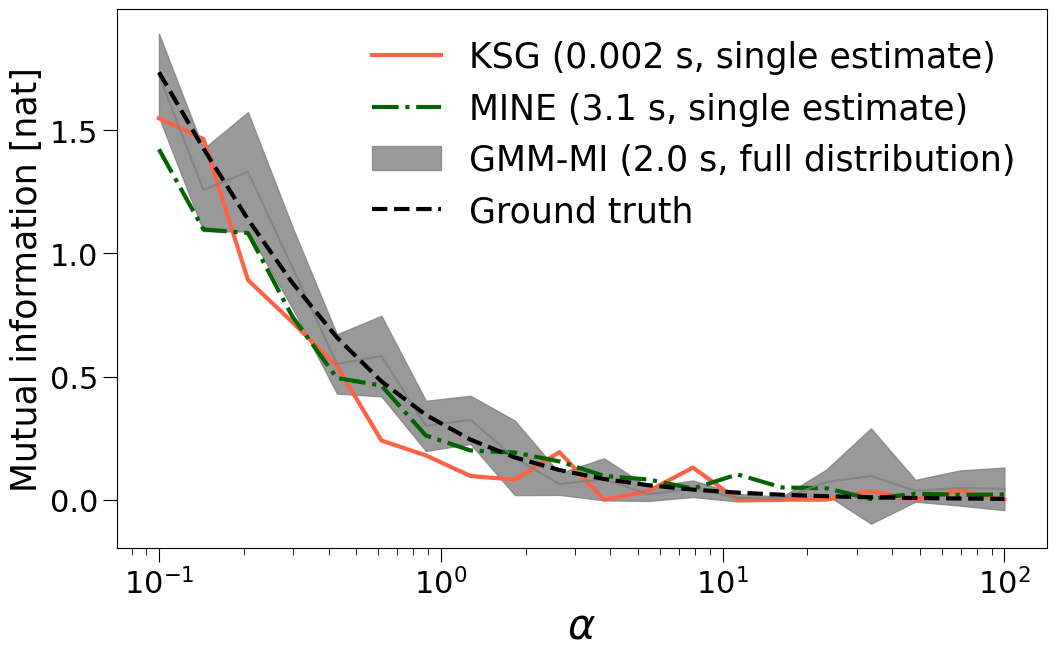

In [8]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

sigmas = 2
lw=3

ax.tick_params(axis='both', which='major', labelsize=22, size=10)
ax.tick_params(axis='both', which='minor', labelsize=22, size=5)
ax.plot(alphas, knn_estimates, c='tomato', lw=lw, label=f'KSG ({ksg_time/len(alphas):.3f} s, single estimate)')
ax.plot(alphas, mine_estimates, c='darkgreen', ls='-.', lw=lw, label=f'MINE ({mine_time/len(alphas):.1f} s, single estimate)')
ax.plot(alphas, all_MI_estimates[:, 0], color='grey', alpha=0.8)
ax.fill_between(alphas, all_MI_estimates[:, 0] - sigmas*all_MI_estimates[:, 1], 
                all_MI_estimates[:, 0]+sigmas*all_MI_estimates[:, 1], 
                color='grey', alpha=0.8, label=f'GMM-MI ({gmm_mi_time/len(alphas):.1f} s, full distribution)')
ax.plot(alphas, analytic, ls='--', c='black', lw=lw, label='Ground truth')

ax.legend(fontsize=25, frameon=False)
        
ax.set_xlabel(r'$\alpha$', fontsize=30)
ax.set_ylabel('Mutual information [nat]', fontsize=25);

ax.set_xscale('log')

plt.savefig('./figures/exp_exp_comparison.pdf',  bbox_inches='tight');